# Data Query & Visualisation using LLM Agents from Scratch

In this notebook, we will build a tool from scratch that allows querying across various structured datasets, such as tables, CSVs, and DataFrames. This tool is designed to conduct data analysis and generate charts or graphs for enhanced visualization and understanding of the data. It leverages LLaMA 3.2–90B-text and LangChain’s agentic framework to automatically interpret query types and respond with either text or visual outputs. We will use GROQ, a free LLM inferencing platform, to implement LLaMA 3.2.

### We are going to use Financial Tabular dataset from Kaggle.

This dataset compiles information from the 10-K annual reports and balance sheets of various companies, featuring longitudinal or panel data spanning from 2009 to 2022. The companies are categorized by their stock classifications. Below is a preview of the dataset.

In [ ]:
### Dataset - https://www.kaggle.com/datasets/rish59/financial-statements-of-major-companies2009-2023?resource=downloadb

Let us start with setting the environment variables. Set the below environment variables in a .env file. <BR><br>
GROQ_API_KEY= <Get the free api key from https://console.groq.com/playground> <BR><br>
Once set with the environment variables, lets do the installation of the packages needed.

In [727]:
%pip install langchain
%pip install langchainhub
%pip install langchain-community
%pip install python-dotenv
%pip install pandas
%pip install numpy
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
  Using cached urllib3-2.2.3-py3-none-any.whl.metadata (6.5 kB)
Using cached urllib3-2.2.3-py3-none-any.whl (126 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.20
    Uninstalling urllib3-1.26.20:
      Successfully uninstalled urllib3-1.26.20
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyppeteer 2.0.0 requires urllib3<2.0.0,>=1.25.8, but you have urllib3 2.2.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use upd

## Now lets load the needed packages and the environment variables.

In [705]:
import json
import pandas as pd
from typing import Dict
from langchain_groq import ChatGroq
from langchain_core.prompts import PromptTemplate
from langchain.agents import create_react_agent
from langchain.agents import AgentExecutor

import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()

Matplotlib is building the font cache; this may take a moment.


True

In [232]:
df = pd.read_csv("./Financial Statements.csv")

In [233]:
df.columns

Index(['Year', 'Company ', 'Category', 'Market Cap(in B USD)', 'Revenue',
       'Gross Profit', 'Net Income', 'Earning Per Share', 'EBITDA',
       'Share Holder Equity', 'Cash Flow from Operating',
       'Cash Flow from Investing', 'Cash Flow from Financial Activities',
       'Current Ratio', 'Debt/Equity Ratio', 'ROE', 'ROA', 'ROI',
       'Net Profit Margin', 'Free Cash Flow per Share',
       'Return on Tangible Equity', 'Number of Employees',
       'Inflation Rate(in US)'],
      dtype='object')

### Optional:  After loading the packages,  lets load, filter the Dataset & save the filtered data for querying. 

In [234]:
df_filtered = df[['Year', 'Company ', 'Market Cap(in B USD)', 'Revenue',
       'Gross Profit', 'Net Income', 'Earning Per Share',
       'Debt/Equity Ratio', 'ROE', 'ROA', 'ROI', 'Inflation Rate(in US)'
       ]]

In [235]:
df_filtered.to_csv("./Financial_Statements_filtered.csv", index=False)

### Implementing different components of Agent.

### 1) Large Language Model (LLMs)

You can use any LLMs capable of reasoning and executing function calls. Typically, models with 70 billion parameters or more perform better for agentic tasks, as smaller models are more prone to hallucination and may struggle with providing accurate reasoning.

In [427]:
import os

llm = ChatGroq(
    groq_api_key=os.environ.get("GROQ_API_KEY"),
    model_name='llama-3.1-70b-versatile'
)

### Printing the default ReAct prompt so that we can use it as a base and modify it for our Usecase

In [428]:
from langchain import hub

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/react")
print(prompt.template)

/Users/akashmodi/git-repo/useful_code_base/LangGraph/.venv/lib/python3.12/site-packages/langsmith/client.py:323: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!

Question: {input}
Thought:{agent_scratchpad}


### 2) Tools

We have implemented  multiple tools needed by the Agent to execute the Actions. <br>
**Load_Data** - will load the initial dataset needed for the query.<br>
**get_values_from_dataframe** - extracts the DataFrame from the intermediate results stored in memory.<br>
**execute_dataframe_query** - execute the DataFrame query using query formulated by the LLMs and intermediate results<br>
**plot_chart** - plot the Chart (if needed) from the given DataFrame using Matplotlib.

In [728]:
from langchain_core.tools import tool

"""**Optional**: An additional function is needed to retrieve the descriptions of all the columns in the given dataset. 
Since we are not passing the data to the LLM directly, this function will assist the agent in understanding the dataset 
based on its columns. We will provide the data to the LLM only once (while loading the dataset) to obtain the 
descriptions for each column, and thereafter, we will use the same descriptions in subsequent calls."""


def get_column_desc(df):
    prompt = """
    You are an expert data analyst. you are given dataset in Json format : 

    {input} 
    
    your job is to describe the meaning of the columns in the data set.

    Output:

    """
    prompt = PromptTemplate.from_template(prompt)

    chain = prompt | llm

    response = chain.invoke({"input": df.to_json()})    

    return response.content

@tool
def plot_chart(dataframe_name: str):
    """This tool takes a dataframe name as string and plots a chart depending the columns in the dataframe.
    the chart is only plotted if there are mutiple rows in the dataframe with one or more columns."""
    global DF_GLOBAL

    df_chart = DF_GLOBAL[dataframe_name]
    if len(df_chart.columns) > 2:
        return "The number of columns are more then 2 please filter the dataframe to have 1 or 2 columns only."
    elif len(df_chart.columns) > 1:
        fig = plt.figure()
        plt.plot(df_chart.iloc[:, 0], df_chart.iloc[:, 1]) 
        print(fig)
        return fig
    else:
        fig = plt.figure()
        plt.plot(df_chart.iloc[:, 0], list(range(len(df_chart.iloc[:, 0])))) 
        return fig
        


@tool
def get_values_from_dataframe(dataframe_name: str):
    """This tool takes a dataframe name as string and gets the data from the dataframe"""
    global DF_GLOBAL
    return DF_GLOBAL[dataframe_name]



@tool
def execute_dataframe_query(query: str) -> str:
    """This tool takes a query as input and executes the query to create new columns or dataframes depending on the query."""
    global DF_GLOBAL, STEP
    for k, v in DF_GLOBAL.items():
        locals()[k] = v

    STEP+=1
    LHS = query.split("=",1)[0].strip()
    RHS = query.split("=",1)[-1].strip()

    if LHS == 'df_new':
        DF_GLOBAL["df_step_"+ str(STEP)] = eval(RHS)
        return f"The result is stored in a new dataframe called {"df_step_"+ str(STEP)}\n"
    else:
        df = LHS.split("['",1)[0].strip()
        column = LHS.split("['",1)[-1].strip()[:-2]
    
        DF_GLOBAL["df_step_"+ str(STEP)] = pd.DataFrame.copy(DF_GLOBAL[df], deep=True)
        DF_GLOBAL["df_step_"+ str(STEP)][column] = eval(RHS)
        return f"The result is stored in a new dataframe called {"df_step_"+ str(STEP)} in new column named {column}\n"

    

@tool
def load_data(filename :str) -> dict:
    """This tool reads the data from a file & provides the agent with the initial data needed"""
    global DF_GLOBAL
    DF_GLOBAL["df_step_0"] = pd.read_csv(filename)
    desc = get_column_desc(DF_GLOBAL["df_step_0"])

    #desc = get_column_desc(DF_GLOBAL["df_step_0"])
    return f"""Only use the below columns for forming the dataframe query :\n  {list(DF_GLOBAL["df_step_0"].columns)}\n 
    Use below description to understand the meaning of each columns:  \n{desc}\n\n
    The result is stored in a new dataframe called "df_step_0"\n"""

### 3) Prompt
We will use a modified version of the ReAct Prompt Template available in the LangChain Hub as 'hwchase17/react.' While the core concept of the ReAct prompt—looping through THOUGHT, ACTION, and OBSERVATION—remains the same, we’ve made several adjustments to tailor the agent to the specific problem we are solving. These modifications include adding rules to assist the agent in generating accurate pandas DataFrame queries. Additionally, we’ve provided a few shot examples in the prompt to improve the quality of the action inputs passed to the tools.

In [722]:
template = """You are an expert in creating pandas DataFrame Query. Answer the following questions as best you can by breaking down complex problem into multiple simple Dataframe Queries.

Stritcly Follow the Below rules:  
    1) you can use the intermediate dataframes created during Obeservation.
    2) Do not include any quotes at the start or end of the query.
    3) Make sure to provide "df_new" as the name of the newely created dataframe.
    4) Make sure to have complete and only one expression per query.
    5) if creating a new column, please use existing DataFrame.

You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the inputs to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question.

Here are some examples of converting statement to pandas dataframe query:

statement: filter the dataframe to get the rows for year 2021
query: df_new = df_step_1[df_step_1['Year'] == 2021] 

statement: Find the company with the highest revenue
query: df_new = df_step_3.loc[df_step_3['Revenue'].idxmax()]

statement: Calculate YoY revenue growth
query: df_step_6['YoY Revenue Growth'] = df_step_6['Revenue'].pct_change() * 100

statement: calculate the cost to company given revenue and profit
query: df_step_3["Cost to company"] = df_step_3["revenue"] - df_step_3["profit"]


Lets Begin!

Question: {input}
Thought:{agent_scratchpad}

"""

## Now we have all the components ready, lets create an Agent.

In [723]:
llm = ChatGroq(
    groq_api_key=os.environ.get("GROQ_API_KEY"),
    model_name='llama-3.2-90b-text-preview',
    temperature=0
)
prompt = PromptTemplate.from_template(template)
tools = [load_data, execute_dataframe_query, get_results, plot_chart]
agent = create_react_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent= agent, tools=tools, verbose=True)

## Agent Execution

Error in StdOutCallbackHandler.on_chain_start callback: AttributeError("'NoneType' object has no attribute 'get'")


Thought: To plot the chart for YoY revenue of AAPL, I need to first load the data from the Financial_Statements_filtered.csv file.

Action: load_data
Action Input: Financial_Statements_filtered.csvOnly use the below columns for forming the dataframe query :
  ['Year', 'Company', 'Market Cap(in B USD)', 'Revenue', 'Gross Profit', 'Net Income', 'Earning Per Share', 'Debt/Equity Ratio', 'ROE', 'ROA', 'ROI', 'Inflation Rate(in US)']
 
    Use below description to understand the meaning of each columns:  
The dataset contains financial information about various companies over several years. Here's a description of each column:

1. **Year**: This column represents the year for which the financial data is reported.

2. **Company**: This column contains the ticker symbol of the company, which is a unique identifier for publicly traded companies.

3. **Market Cap (in B USD)**: This column represents the market capitalization of the company in billions of US dollars. Market capitalization is the

{'input': 'plot me chart for YoY revenue of AAPL from Financial_Statements_filtered.csv',
 'output': 'The chart for YoY revenue of AAPL from Financial_Statements_filtered.csv has been plotted.'}

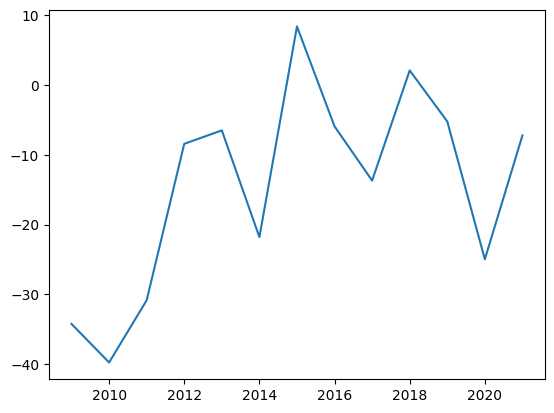

In [725]:
DF_GLOBAL = {}
STEP = 0
agent_executor.invoke({"input": "plot me chart for YoY revenue of AAPL from Financial_Statements_filtered.csv"})

#agent_executor.invoke({"input": "which company has 2nd highest revenue between 2021 from  Financial_Statements_filtered.csv"})

In [716]:
#DF_GLOBAL['df_step_3']

,Year,YoY Revenue Growth
0,2022,NaN
1,2021,-7.230275
2,2020,-24.958381
3,2019,-5.224123
4,2018,2.083606
5,2017,-13.690393
6,2016,-5.930621
7,2015,8.382528
8,2014,-21.787219
9,2013,-6.501819


In [717]:
DF_GLOBAL['df_step_2']

,Year,Company,Market Cap(in B USD),Revenue,Gross Profit,Net Income,Earning Per Share,Debt/Equity Ratio,ROE,ROA,ROI,Inflation Rate(in US),YoY Revenue Growth
0,2022,AAPL,2066.94,394328.0,170782.0,99803.0,6.1100,2.3695,196.9589,28.2924,66.6994,8.0028,NaN
1,2021,AAPL,2913.28,365817.0,152836.0,94680.0,5.6100,1.9768,150.0713,26.9742,54.9839,4.6979,-7.230275
2,2020,AAPL,2255.97,274515.0,104956.0,57411.0,3.2800,1.7208,87.8664,17.7256,35.0054,1.2336,-24.958381
3,2019,AAPL,1304.76,260174.0,98392.0,55256.0,2.9700,1.1940,61.0645,16.3230,30.3113,1.8122,-5.224123
4,2018,AAPL,748.54,265595.0,101839.0,59531.0,2.9800,1.0685,55.5601,16.2775,29.6348,2.4426,2.083606
5,2017,AAPL,868.87,229234.0,88186.0,48351.0,2.3025,0.8630,36.0702,12.8826,20.9082,2.1301,-13.690393
6,2016,AAPL,617.59,215639.0,84263.0,45687.0,2.0775,0.6786,35.6237,14.2024,22.4312,1.2616,-5.930621
7,2015,AAPL,586.86,233715.0,93626.0,53394.0,2.3050,0.5390,44.7355,18.3899,30.9201,0.1186,8.382528
8,2014,AAPL,647.36,182795.0,70537.0,39510.0,1.6125,0.3164,35.4201,17.0420,28.1142,1.6222,-21.787219
9,2013,AAPL,504.79,170910.0,64304.0,37037.0,1.4200,0.1373,29.9776,17.8923,26.3592,1.4648,-6.501819


In [720]:
df

,Year,Company,Category,Market Cap(in B USD),Revenue,Gross Profit,Net Income,Earning Per Share,EBITDA,Share Holder Equity,...,Current Ratio,Debt/Equity Ratio,ROE,ROA,ROI,Net Profit Margin,Free Cash Flow per Share,Return on Tangible Equity,Number of Employees,Inflation Rate(in US)
0,2022,AAPL,IT,2066.94,394328.0,170782.0,99803.0,6.1100,130541.0,50672.0,...,0.8794,2.3695,196.9589,28.2924,66.6994,25.3096,1.3146,196.9589,164000,8.0028
1,2021,AAPL,IT,2913.28,365817.0,152836.0,94680.0,5.6100,120233.0,63090.0,...,1.0746,1.9768,150.0713,26.9742,54.9839,25.8818,1.3261,150.0713,154000,4.6979
2,2020,AAPL,IT,2255.97,274515.0,104956.0,57411.0,3.2800,77344.0,65339.0,...,1.3636,1.7208,87.8664,17.7256,35.0054,20.9136,1.0183,87.8664,147000,1.2336
3,2019,AAPL,IT,1304.76,260174.0,98392.0,55256.0,2.9700,76477.0,90488.0,...,1.5401,1.1940,61.0645,16.3230,30.3113,21.2381,-0.0388,61.0645,137000,1.8122
4,2018,AAPL,IT,748.54,265595.0,101839.0,59531.0,2.9800,81801.0,107147.0,...,1.1329,1.0685,55.5601,16.2775,29.6348,22.4142,0.7414,55.5601,132000,2.4426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
156,2013,AMZN,LOGI,182.54,74452.0,20271.0,274.0,0.0295,3998.0,9746.0,...,1.0716,0.3274,2.8114,0.6823,2.1180,0.3680,0.1748,3.8641,117300,1.4648
157,2012,AMZN,LOGI,113.63,61093.0,15122.0,-39.0,-0.0045,2835.0,8192.0,...,1.1207,0.3765,-0.4761,-0.1198,-0.3459,-0.0638,-0.1833,-0.6915,88400,2.0693
158,2011,AMZN,LOGI,78.72,48077.0,10789.0,631.0,0.0685,1945.0,7757.0,...,1.1741,0.0329,8.1346,2.4962,7.8757,1.3125,-0.0490,10.8756,56200,3.1568
159,2010,AMZN,LOGI,80.79,34204.0,7643.0,1152.0,0.1265,1974.0,6864.0,...,1.3254,0.2274,16.7832,6.1286,13.6736,3.3680,-0.0544,20.8885,33700,1.6400
